In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tf_ms_ssim
import sys
sys.path.insert(0,'/home/dirty_mike/Dropbox/github/image_quality_analysis/bin')
import iqa_tools as iqa
import tensorflow as tf
from tensorflow.python.saved_model import tag_constants
from scipy import signal
from scipy.ndimage.filters import convolve

In [2]:
# writing a single image pair to file to demo with ms_ssim code
data_path = '/home/dirty_mike/Dropbox/github/image_quality_analysis/data/sample_data/'

orig_500 = pd.read_csv('{}orig_500.txt'.format(data_path), header=None, delim_whitespace = True).values.reshape(500,96,96)
recon_500 = pd.read_csv('{}recon_500.txt'.format(data_path), header=None, delim_whitespace = True).values.reshape(500,96,96)

In [4]:
msssim_res = []
for ii in range(500):
    res = tf_ms_ssim.MultiScaleSSIM(np.reshape(orig_500[ii,:,:], [1,96,96,1]), np.reshape(recon_500[ii,:,:], [1,96,96,1]))
    msssim_res.append(res)

/usr/local/lib/python3.5/dist-packages/scipy/signal/signaltools.py:375: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  complex_result = (np.issubdtype(in1.dtype, complex) or
/usr/local/lib/python3.5/dist-packages/scipy/signal/signaltools.py:376: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  np.issubdtype(in2.dtype, complex))


In [6]:
np.mean(msssim_res), np.std(msssim_res)

(0.9054053585150457, 0.029498462759533703)

In [30]:
def _FSpecialGauss(size, sigma):
    radius = size // 2
    offset = 0.0
    start, stop = -radius, radius + 1
    if size % 2 == 0:
        offset = 0.5
        stop -= 1
    x, y = np.mgrid[offset + start:stop, offset + start:stop]
    assert len(x) == size
    g = np.exp(-((x**2 + y**2)/(2.0 * sigma**2)))
    return g / g.sum()


def _SSIMForMultiScale(img1, img2, max_val=255, filter_size=11,
                       filter_sigma=1.5, k1=0.01, k2=0.03):
    if img1.shape != img2.shape:
        raise RuntimeError('Input images must have the same shape (%s vs. %s).',
                       img1.shape, img2.shape)
    if img1.ndim != 4:
        raise RuntimeError('Input images must have four dimensions, not %d',
                       img1.ndim)

    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    _, height, width, _ = img1.shape

    # Filter size can't be larger than height or width of images.
    size = min(filter_size, height, width)
    
    # Scale down sigma if a smaller filter size is used.
    sigma = size * filter_sigma / filter_size if filter_size else 0

    if filter_size:
        window = np.reshape(_FSpecialGauss(size, sigma), (1, size, size, 1))
        mu1 = signal.fftconvolve(img1, window, mode='valid')
        print(mu1.shape)
        mu2 = signal.fftconvolve(img2, window, mode='valid')
        sigma11 = signal.fftconvolve(img1 * img1, window, mode='valid')
        sigma22 = signal.fftconvolve(img2 * img2, window, mode='valid')
        sigma12 = signal.fftconvolve(img1 * img2, window, mode='valid')
    else:
        # Empty blur kernel so no need to convolve.
        mu1, mu2 = img1, img2
        sigma11 = img1 * img1
        sigma22 = img2 * img2
        sigma12 = img1 * img2

    mu11 = mu1 * mu1
    mu22 = mu2 * mu2
    mu12 = mu1 * mu2
    sigma11 -= mu11
    sigma22 -= mu22
    sigma12 -= mu12

    # Calculate intermediate values used by both ssim and cs_map.
    c1 = (k1 * max_val) ** 2
    c2 = (k2 * max_val) ** 2
    v1 = 2.0 * sigma12 + c2
    v2 = sigma11 + sigma22 + c2
    ssim = np.mean((((2.0 * mu12 + c1) * v1) / ((mu11 + mu22 + c1) * v2)))
    cs = np.mean(v1 / v2)
    return ssim, cs
_SSIMForMultiScale(demo_images[0],demo_images[1])

(1, 86, 86, 1)


/usr/local/lib/python3.5/dist-packages/scipy/signal/signaltools.py:375: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  complex_result = (np.issubdtype(in1.dtype, complex) or
/usr/local/lib/python3.5/dist-packages/scipy/signal/signaltools.py:376: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  np.issubdtype(in2.dtype, complex))


(0.6324433225363714, 0.6763697750299543)

In [10]:
demo_images = [np.reshape(orig_500[0,:,:], [1,96,96,1]),np.reshape(recon_500[0,:,:], [1,96,96,1])]
demo_images[0].shape

(1, 96, 96, 1)

In [27]:
size=11;sigma=1.5
x = np.reshape(_FSpecialGauss(size, sigma), (1, size, size, 1))

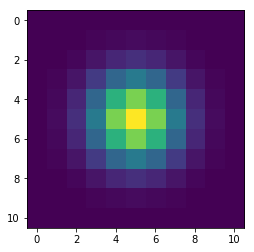

In [24]:
plt.imshow(x[0,:,:,0])
plt.show()

In [ ]:

def MultiScaleSSIM(img1, img2, max_val=255, filter_size=11, filter_sigma=1.5,
                   k1=0.01, k2=0.03, weights=None):
    if img1.shape != img2.shape:
        raise RuntimeError('Input images must have the same shape (%s vs. %s).',
                       img1.shape, img2.shape)
    if img1.ndim != 4:
        raise RuntimeError('Input images must have four dimensions, not %d',
                       img1.ndim)

    # Note: default weights don't sum to 1.0 but do match the paper / matlab code.
    weights = np.array(weights if weights else
                     [0.0448, 0.2856, 0.3001, 0.2363, 0.1333])
    levels = weights.size
    downsample_filter = np.ones((1, 2, 2, 1)) / 4.0
    im1, im2 = [x.astype(np.float64) for x in [img1, img2]]
    mssim = np.array([])
    mcs = np.array([])
    for _ in range(levels):
        ssim, cs = _SSIMForMultiScale(
            im1, im2, max_val=max_val, filter_size=filter_size,
            filter_sigma=filter_sigma, k1=k1, k2=k2)
        mssim = np.append(mssim, ssim)
        mcs = np.append(mcs, cs)
        filtered = [convolve(im, downsample_filter, mode='reflect')
                for im in [im1, im2]]
        im1, im2 = [x[:, ::2, ::2, :] for x in filtered]
    return (np.prod(mcs[0:levels-1] ** weights[0:levels-1]) *
          (mssim[levels-1] ** weights[levels-1]))
